# **Analysis of COVID-19 Cases in Malaysia**
Hello all, in this notebook, we will see how COVID-19 has progressed in Malaysia since the first case was announced.

**Current Updates**

1. Please take note that some of the dates have insufficient data, especially on the earlier part of the 1st wave (22nd Jan 2020-26th February 2020).

2. Malaysia is currently under the 2nd wave of COVID-19, surging from <100 cases to ~4700 cases as of 12th April 2020 (since 27th February 2020). [Source](https://www.thestar.com.my/news/nation/2020/03/23/covid-19-current-situation-in-malaysia-updated-daily) 

3. Malaysia has taken the initative to perform Movement Control Order(MCO) for 14 days starting from 18th March 2020 until 31st of March 2020. There were series of additional MCO phase, and as of 27th July 2020, Malaysia is under the Recovery Movement Control Order (RMCO). 

4. We have successfully flatten the curve, however, there were an increased number of cases in the latter half of July.

5. Data that was used for the by-state analysis is up until early of May, whereas general Malaysia data is [updated](https://www.kaggle.com/imdevskp/corona-virus-report) daily.


<center>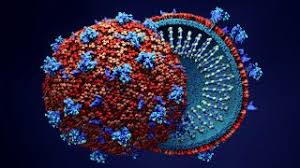</center>


### <center> Coronavirus</center>



### Please leave a comment for further improvements. Thanks!
#### Download updated world stats at https://www.kaggle.com/imdevskp/corona-virus-report
   





In [ ]:
# import 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.pyplot import figure
import folium
import geopandas as gpd
from folium.plugins import TimestampedGeoJson
import math
import seaborn as sns
sns.set()

from pathlib import Path
data_dir = Path('../input')

import os
os.listdir(data_dir)


In [ ]:
#import csv file for all country. We can do comparative analysis later 
cleaned_data = pd.read_csv(data_dir/'corona-virus-report/covid_19_clean_complete.csv', parse_dates=['Date'])
cleaned_data.head()

In [ ]:
cleaned_data.rename(columns={'ObservationDate': 'date', 
                     'Province/State':'state',
                     'Country/Region':'country',
                     'Last Update':'last_updated',
                     'Confirmed': 'confirmed',
                     'Deaths':'deaths',
                     'Recovered':'recovered'
                    }, inplace=True)

# cases 
cases = ['confirmed', 'deaths', 'recovered', 'active']

# Active Case = confirmed - deaths - recovered
cleaned_data['active'] = cleaned_data['confirmed'] - cleaned_data['deaths'] - cleaned_data['recovered']

# replacing Mainland china with just China
cleaned_data['country'] = cleaned_data['country'].replace('Mainland China', 'China')

# filling missing values 
cleaned_data[['state']] = cleaned_data[['state']].fillna('')
cleaned_data[cases] = cleaned_data[cases].fillna(0)
cleaned_data.rename(columns={'Date':'date'}, inplace=True)

data = cleaned_data

In [ ]:
#date stuff
print("External Data")
print(f"Earliest Entry: {data['date'].min()}")
print(f"Last Entry:     {data['date'].max()}")
print(f"Total Days:     {data['date'].max() - data['date'].min()}")

data.head()

# General Outlook

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots

In [ ]:
formated_gdf = data.groupby(['date', 'country'])['confirmed', 'deaths'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['date'] = pd.to_datetime(formated_gdf['date'])
formated_gdf['date'] = formated_gdf['date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['confirmed'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="country", locationmode='country names', 
                     color="confirmed", size='size', hover_name="country", 
                     range_color= [0, 1500], 
                     projection="natural earth", animation_frame="date", scope='world', 
                     title='COVID-19: Spread Over Time', color_continuous_scale="portland",width=900, height=500)
# fig.update(layout_coloraxis_showscale=False)
fig.show()

# Malaysia Analysis

# Confirmed and Active Cases


In [ ]:
#extract rows pertinent to Malaysia only
myr = data[data['country']=='Malaysia']
myr.reset_index(drop=True, inplace=True)
myr

In [ ]:
figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Confirmed & Active Cases in Malaysia')
plt.xlabel('Date')
plt.ylabel('# of Cases')

plt.plot(myr.date,myr.confirmed,'-', label='Confirmed')
plt.plot(myr.date,myr.active,'-', label= 'Active Cases')



plt.grid(alpha=0.2)
plt.legend(loc="upper left")

# New Cases Since RMO


In [ ]:
drmo=myr.date[56:]
crmo=myr.confirmed[56:]

fig, ax = plt.subplots(figsize=(14,10))
plt.title('Number of Cases Since RMO')
sns.lineplot(x = drmo, y=crmo)
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)

# New Cases Daily

In [ ]:
#number of new cases calculation
n=1
newcase=[0]
while n < len(myr.confirmed):
    newcase.append(myr.confirmed[n] - myr.confirmed[n-1])
    n+=1
    
day = np.array(range(1,len(newcase)+1))

In [ ]:
figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')

plt.xlabel('Day')
plt.ylabel('# of New Cases')
plt.title('New Cases in Malaysia Starting from 22-1-2020')

#Add vertical Line Representing Mean
plt.axvline(60,color='gray',linestyle='--')
plt.text(x=60, y=220, s=' MCO 1', alpha=0.7, color='#334f8d')


plt.bar(day,newcase, label= 'New Cases', color='#4b8bbe')

plt.legend(loc="upper left")
plt.grid(alpha=0.8)


# Closed Cases in Malaysia

In [ ]:
figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Date')
plt.ylabel('# of Cases')
plt.title('Closed Cases in Malaysia')


plt.plot(myr.date,myr.recovered,'-', label='Recovered', color='blue')
plt.plot(myr.date,myr.deaths,'-', label= 'Deaths',color='green')
#plt.plot(myr.date,newcase,'.', label= 'New Cases', color='r')

plt.grid(alpha=0.2)
plt.legend(loc="upper left")

Our recovery rate is doing pretty good compared to the death rate, and it is rising in an exponential manner

# By-State Analysis

In [ ]:
#load data
statepath=Path(data_dir/'covid19-world-malaysiaby-state-dataset/covid-malaysia-bystate.csv')
dfstate=pd.read_csv(statepath,encoding='latin1')
dfstate.head()

### Data Exploration

In [ ]:
dfstate.info()

In [ ]:
dfstate.total.tail()

In [ ]:
#dataframe for each state

ked = dfstate[dfstate['state']=='Kedah']
mel = dfstate[dfstate['state']=='Melaka']
kel = dfstate[dfstate['state']=='Kelantan']
kl = dfstate[dfstate['state']=='KL&Putrajaya']
per = dfstate[dfstate['state']=='Perlis']
pen = dfstate[dfstate['state']=='P.Pinang']
n9 = dfstate[dfstate['state']=='N. Sembilan']
joh = dfstate[dfstate['state']=='Johor']
pah = dfstate[dfstate['state']=='Pahang']
sab = dfstate[dfstate['state']=='Sabah']
sar = dfstate[dfstate['state']=='Sarawak']
lab = dfstate[dfstate['state']=='Labuan']
sel = dfstate[dfstate['state']=='Selangor']
ter = dfstate[dfstate['state']=='Terengganu']
rak = dfstate[dfstate['state']=='Perak']

## Bar Race Chart

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.animation as animation
current_date= '12-04-20'
dt29 = dfstate[dfstate['date'].eq(current_date)].sort_values(by='total').head(15)
dt29

In [ ]:
colors = dict(zip(
    ['Labuan','Perlis','Melaka','Terengganu', 'Kedah', 'Pahang', 'P.Pinang', 'Kelantan', 'Sarawak', 'N.Sembilan', 'Perak', 'Sabah', 'Johor', 'KL&Putrajaya', 'Selangor'],
    ['#adb0ff', '#ffb3ff', '#90d595', '#e48381',
     '#aafbff', '#f7bb5f', '#eafb50','red','brown','blue','yellow','blue','green','purple','gray']
))
group_lk = dfstate['state'].to_dict()

In [ ]:
def draw_barchart(date):
    dt29 = dfstate[dfstate['date'].eq(date)].sort_values(by='total').head(15)
    ax.clear()
    ax.barh(dt29['state'],dt29['total'], color=[colors[x] for x in dt29['state']])
    #dx = dff['value'].max() / 200
    
    # iterate over the values to plot labels and values (Tokyo, Asia, 38194.2)
    for i, (total, state) in enumerate(zip(dt29['total'], dt29['state'])):
        ax.text(total, i,     state,            ha='right')  # Tokyo: name
        #ax.text(total, i-.25, group_lk[name],  ha='right')  # Asia: group name
        ax.text(total, i,     total,           ha='left')   # 38194.2: value
        
    # ... polished styles
    ax.text(1, 0.4, date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Cases', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'Number of Cases By State',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    ax.text(1, 0, 'by Khairul Hafiz; credit Khairul Hafiz', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)

In [ ]:
#flourish produced better visualization: refer to https://public.flourish.studio/story/407202/


from IPython.display import HTML
fig, ax = plt.subplots(figsize=(20, 12))
animator = animation.FuncAnimation(fig, draw_barchart, frames= ked.date)
HTML(animator.to_jshtml()) 

## States with The Highest Cases

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
plt.title('States with The Highest Cases in Malaysia')



plt.plot(kl.date,kl.total, label='KL & Putrajaya')
plt.plot(joh.date,joh.total, label='Johor')
plt.plot(sar.date,sar.total, label='Sarawak')
plt.plot(sel.date,sel.total, label='Selangor')

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)

plt.xticks(rotation=65)
plt.grid(alpha=0.8)
plt.legend(loc="upper left")
plt.xlabel('Date')
plt.ylabel('# of Cases')

## Other States

In [ ]:
figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Other States and Their Respective Cases in Malaysia')

plt.plot(ked.date,ked.total, label='Kedah')
plt.plot(mel.date,mel.total, label='Melaka')
plt.plot(kel.date,kel.total, label='Kelantan')
plt.plot(per.date,per.total, label='Perlis')
plt.plot(pen.date,pen.total, label='Pulau Pinang')
plt.plot(n9.date,n9.total, label='Negeri Sembilan')
plt.plot(pah.date,pah.total, label='Pahang')
plt.plot(lab.date,lab.total, label='Labuan')
plt.plot(ter.date,ter.total, label='Terengganu')
plt.plot(rak.date,rak.total, label='Perak')
plt.plot(sab.date,sab.total, label='Sabah')

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)

plt.xticks(rotation=65)
plt.grid(alpha=0.8)
plt.legend(loc="upper left")
plt.xlabel('Date')
plt.ylabel('# of Cases')

# Geographical Representation (by states)

In [ ]:
latest=dfstate[dfstate['date']=='04-05-20']
latest.reset_index(level=0,drop=True, inplace=True)
latest.set_index('state', inplace=True)
latest.sort_values(by='death', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
latest

In [ ]:
latest.index

In [ ]:
# duplicating coordinates according to column -- not needed for now
# no differences in heatmap output
heat_cord = []

def heatcord(state):
    i=0
    while i <= latest.at[state,'total']:
        heat_cord.append([latest.at[state,'Latitude'],latest.at[state,'Longitude']])
        i+=1
    return 
        
for row in latest.index: 
     heatcord(row)

heat_map = pd.DataFrame(heat_cord,columns = ['Latitude', 'Longitude'])

In [ ]:
#normalization of total cases

tot_latest= latest.total.sum()
norm_today=(latest.total)/float(tot_latest)
norm_today

## Malaysia

In [ ]:
my = folium.Map(width=1200,height=800,location=[4.824330, 108.304785],
        zoom_start=6) #tiles= Stamen Terrain, Stamen Toner,  

cir=150

def state_circle(MYState,warna):
    folium.CircleMarker(
        location=[latest.at[MYState,'Latitude'],latest.at[MYState,'Longitude']],
        radius=norm_today[MYState]*cir,
        popup=str(MYState),
        color=warna,
        fill=True,
        fill_color=warna,
        alpha=0.1
    ).add_to(my)

for row in latest.index: 
     state_circle(row,'#3186cc')
        
state_circle('KL&Putrajaya','red')  
my

## Peninsular Malaysia

In [ ]:
#def make_map(features):
m = folium.Map(width=1200,height=800,location=[4.000, 102.295999],
        zoom_start=6.5) #tiles= Stamen Terrain, Stamen Toner, 

cir=200

def state_circle(MYState,warna):
    folium.CircleMarker(
        location=[latest.at[MYState,'Latitude'],latest.at[MYState,'Longitude']],
        radius=norm_today[MYState]*cir,
        popup=str(MYState),
        color=warna,
        fill=True,
        fill_color=warna,
        alpha=0.1
    ).add_to(m)
    #return

for row in latest.index: 
    if row !='Sarawak' and row != "Sabah" and row !="Labuan":
        state_circle(row,'#3186cc')
        
state_circle('KL&Putrajaya','red')
m

## Borneo

In [ ]:
ss = folium.Map(width=1000,height=800,location=[3.412054, 114.493331],
        zoom_start=6.5) #tiles= Stamen Terrain, Stamen Toner, 

def state_circle(MYState,warna):
    folium.CircleMarker(
        location=[latest.at[MYState,'Latitude'],latest.at[MYState,'Longitude']],
        radius=norm_today[MYState]*cir,
        popup=str(MYState),
        color=warna,
        fill=True,
        fill_color=warna,
        alpha=0.1
    ).add_to(ss)

for row in latest.index: 
    if row =='Sarawak' or row == "Sabah" or row=="Labuan":
        state_circle(row,'#3186cc')
        
ss

Khairul Hafiz 

khairulhafiz38@gmail.com